# Gravitational Orbits in Cartesian Coordinates
Created By: Autumn Stephens <br>
Creation Date: 3/26/2023

In [1]:
### Imports necessary packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

Consider a system of two bodies with masses $m_1$ and $m_2$ located at $r_1=(x_1, y_1, z_1)$ and $r_2=(x_1, y_1, z_1)$. In Newtonian mechanics, the gravitational force between the two bodies is given by

\begin{equation}
F_g = \frac{G m_1 m_2}{r^2} \hat{r}
\end{equation}

where $r=|r_2-r_1|$. Since the acceleration on each body relates to the gravitational force by 

\begin{equation}
F_g = m \frac{d^2 r}{dt^2} \hat{r} 
\end{equation}

Hence, the acceleration of body 1 at any moment is given by

\begin{equation}
\frac{d^2 r}{dt^2} = \frac{G m_2}{r^2} \hat{r} = \frac{G m_2 (r_2-r_1)}{|r_2-r_1|^3}
\end{equation}

By symmetry, the acceleration of body 2 at any moment is given by

\begin{equation}
\frac{d^2 r}{dt^2} = \frac{G m_1}{r^2} \hat{r} = \frac{G m_1 (r_2-r_1)}{|r_2-r_1|^3}
\end{equation}

In my TwoBodyProblem class, these are the differential equations solved by the solve_ivp() function. Note that the user specifies the initial velocity of each of these bodies, do a derivation of each equation is not necessary. However, we should note the limiting case where $m_1 >> m_2$, as is the case with most exoplanets orbiting around a host star. In these cases, the large mass $m_1$ is nearly at rest because the gravitational attraction of the smaller mass is much smaller than the large mass's inertia. Hence, we can reduce the problem to a single-body problem where only the smaller mass is in motion. We will see an example of this below when we simulate Earth's orbit around the Sun.

In [2]:
class TwoBodyProblem:
    def __init__(self, m1, m2, r1, r2, v1, v2, G = 6.67430e-11):
        
        """
        Initializes TwoBodyProblem object with user-specified conditions

        Arguments:
        m1 : float 
            mass of body 1
        m2 : float
            mass of body 2
        r1 : numpy.ndarray
            initial position vector of body 1
        r2 : numpy.ndarray
            initial position vector of body 2
        v1 : numpy.ndarray
            initial velocity vector of body 1
        v2 : numpy.ndarray
            initial velocity vector of body 2
        """
        
        ### Initializes system parameters
        self.m1 = m1
        self.m2 = m2
        self.r1 = r1
        self.r2 = r2
        self.v1 = v1
        self.v2 = v2
        self.G = G
        self.r0 = np.array([r1, r2, v1, v2]).flatten() # initial state vector
    
    def rhs_func(self, t, y):
        """
        Calculates right-hand side of the differential equation as a function of time and the state vector.

        Arguments:
        t : float
            current time
        y : numpy.ndarray
            current state vector

        Returns:
        dy/dt : numpy.ndarray
            derivative of the state vector
        """
        
        ### Extracts body parameters from y vector
        r1 = y[0:3]
        r2 = y[3:6]
        v1 = y[6:9]
        v2 = y[9:12]
        
        ### Calculates r vector and its magnitude
        r12 = r2 - r1
        norm_r12 = np.linalg.norm(r12)
        
        ### Defines the speed and acceleration of each body
        dr1_dt = v1
        dr2_dt = v2
        dv1_dt = (self.G * self.m2 / norm_r12**3) * r12
        dv2_dt = -(self.G * self.m1 / norm_r12**3) * r12
        
        return np.concatenate([dr1_dt, dr2_dt, dv1_dt, dv2_dt])
    
    def solve(self, t_span, t_eval):
        
        """
        Solves the differential equation using the solve_ivp function

        Arguments:
        t_span : tuple
            initial and final times
        t_eval : array
            times to evaluate solution over
        """
        
        ### Solves the differential equation
        sol = solve_ivp(self.rhs_func, t_span, self.r0, t_eval=t_eval, rtol=1e-6, atol=1e-9)
        self.t = sol.t
        self.r = sol.y[:6].T
        self.v = sol.y[6:].T
        
    def solve_leapfrog(self, t_span, t_eval):
        
        """
        Solves the differential equation using the Leapfrog method

        Arguments:
        t_span : tuple 
            initial and final times
        t_eval : array 
            times to evaluate solution over
        """
        
        ### Calculate time steps #
        n_steps = len(t_eval) - 1

        ### Initialize arrays for positions and velocities
        r = np.zeros((n_steps+1, 2, 3))
        v = np.zeros((n_steps+1, 2, 3))
        r[0] = np.array([self.r1, self.r2])
        v[0] = np.array([self.v1, self.v2])

        ### Calculate time step
        dt = t_eval[1] - t_eval[0]

        ### Calculate first half-step velocities
        r12 = r[0,1] - r[0,0]
        norm_r12 = np.linalg.norm(r12)
        a1 = (self.G * self.m2 / norm_r12**3) * r12
        a2 = -(self.G * self.m1 / norm_r12**3) * r12
        v[0,0] += 0.5*dt*a1
        v[0,1] += 0.5*dt*a2

        ### Iterate over time steps
        for i in range(n_steps):
            
            ### Update positions using current velocities
            r[i+1] = r[i] + dt*v[i]

            ### Calculate acceleration at new positions
            r12 = r[i+1,1] - r[i+1,0]
            norm_r12 = np.linalg.norm(r12)
            a1 = (self.G * self.m2 / norm_r12**3) * r12
            a2 = -(self.G * self.m1 / norm_r12**3) * r12

            ### Update velocities using new and old accelerations
            v[i+1,0] = v[i,0] + dt*a1
            v[i+1,1] = v[i,1] + dt*a2

        self.t = t_eval
        self.r = r
        self.v = v

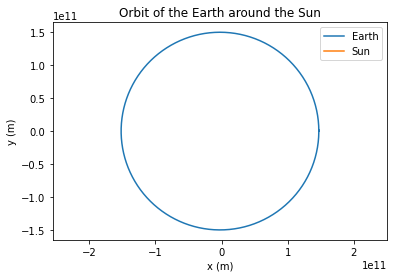

In [3]:
### Instantiate the TwoBodyProblem class
m_earth = 5.972e24
m_sun = 1.989e30
r_earth = np.array([147e9, 0, 0])
r_sun = np.array([0, 0, 0])
v_earth = np.array([0, 30.29e3, 0])
v_sun = np.array([0, 0, 0])
earth_sun = TwoBodyProblem(m_earth, m_sun, r_earth, r_sun, v_earth, v_sun)

### Solve for time of one year
t_span = (0, 365 * 24 * 3600) # one year in seconds
t_eval = np.linspace(0, 365 * 24 * 3600, 365)
earth_sun.solve(t_span, t_eval)

### Plot parameterized plot of each orbit
plt.plot(earth_sun.r[:, 0], earth_sun.r[:, 1], label='Earth')
plt.plot(earth_sun.r[:, 3], earth_sun.r[:, 4], label='Sun')

### Plot labels
plt.axis('equal')
plt.title('Orbit of the Earth around the Sun')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.legend()
plt.show()

As expected, the Sun is functionally stationary, and the Earth orbits about it in a circle. To prove the class is still working as intended, though, here is another simulation where the masses of each body are more similar to each other.

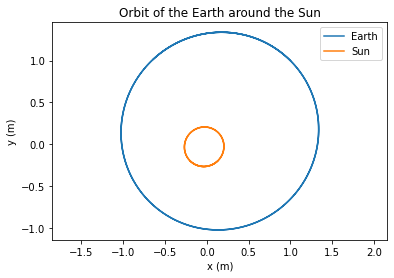

In [4]:
### Instantiate the TwoBodyProblem class
m_1 = 1
m_2 = 5
r_1 = np.array([1, 1, 0])
r_2 = np.array([-(m_1/m_2) * r_1[0], -(m_1/m_2) * r_1[1], 0])
v_1 = np.array([-1, 1, 0])
v_2 = np.array([-(m_1/m_2) * v_1[0], -(m_1/m_2) * v_1[1], 0])
earth_sun = TwoBodyProblem(m_1, m_2, r_1, r_2, v_1, v_2, G=1)

### Solve for time of 10 seconds
t_span = (0, 10) # one year in seconds
t_eval = np.arange(0, 10, 0.01)
earth_sun.solve(t_span, t_eval)

### Plot parameterized plot of each orbit
plt.plot(earth_sun.r[:, 0], earth_sun.r[:, 1], label='Earth')
plt.plot(earth_sun.r[:, 3], earth_sun.r[:, 4], label='Sun')

### Plot labels
plt.axis('equal')
plt.title('Orbit of the Earth around the Sun')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.legend()
plt.show()

## Energy Conservation Analysis

For our two-body system, the total energy is simply given by

\begin{align}
E &= T + U  \\\\
  &= (\frac{1}{2} m_1 v_1^2 + \frac{1}{2} m_2 v_2^2) - \frac{G m_1 m_2}{r^2} \\\\
E &= \frac{1}{2}(m_1 v_1^2 + m_2 v_2^2) - \frac{G m_1 m_2}{(r_2-r_1)^2}
\end{align}

So, by calculating the energy in our simulations at each point in time, we can determine how much energy is lost.

In [9]:
def calc_energies(instance):
    
    m1, m2 = instance.m1, instance.m2
    r1, r2 = instance.r[:,0:3], instance.r[:,3:6]
    v1, v2 = instance.v[:,0:3], instance.v[:,3:6]
    
    T = [1/2 * (m1*np.linalg.norm(a)**2 + m2*np.linalg.norm(b)**2) for a, b in zip(v1, v2)]
    U = [-(instance.G*m1*m2)/(np.linalg.norm(a)-np.linalg.norm(b))**2 for a, b in zip(r1, r2)]
    E = [kinetic + potential for kinetic, potential in zip(T, U)]
    
    return T, U, E

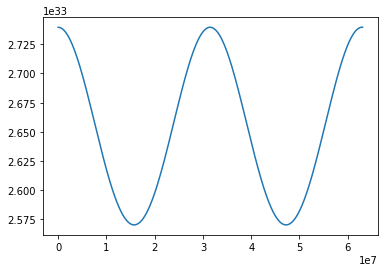

In [13]:
### Instantiate the TwoBodyProblem class
m_earth = 5.972e24
m_sun = 1.989e30
r_earth = np.array([147e9, 0, 0])
r_sun = np.array([0, 0, 0])
v_earth = np.array([0, 30.29e3, 0])
v_sun = np.array([0, 0, 0])
earth_sun = TwoBodyProblem(m_earth, m_sun, r_earth, r_sun, v_earth, v_sun)

### Solve for time of one year
t_span = (0, 2 * 365 * 24 * 3600) # one year in seconds
t_eval = np.linspace(0, 2 * 365 * 24 * 3600, 365)
earth_sun.solve(t_span, t_eval)

T, U, E = calc_energies(earth_sun)

plt.plot(earth_sun.t, E)